### Load Test Data and Trained APG Sampler

In [4]:
%matplotlib inline
import torch
import numpy as np
from apgs.gmm.apg_training import init_apg_models, init_rws_models

CUDA = torch.cuda.is_available()
device = torch.device('cuda:1')
data_dir = '../../data/gmm/'
K, D, num_hidden = 3, 2, 32

data = torch.from_numpy(np.load(data_dir + 'ob_test.npy')).float() 
model_version = 'apg-gmm-block=decomposed-num_sweeps=5-num_samples=20'
models = init_apg_models(K, D, num_hidden, CUDA, device, model_version, lr=None)

### Visualize Samples

In [ ]:
from apgs.resampler import Resampler
from apgs.gmm.objectives import apg_objective
from apgs.gmm.evaluation import viz_samples

batch_size, num_sweeps = 5, 13
batch_data = data[torch.randperm(data.shape[0])[:batch_size]].unsqueeze(0)
if CUDA:
    batch_data = batch_data.cuda().to(device)
result_flags = {'loss_required' : False, 'ess_required' : False, 'mode_required' : True, 'density_required': False}
trace = apg_objective(models, batch_data, result_flags, num_sweeps, 'decomposed', Resampler('systematic', 1, CUDA, device))
viz_samples(batch_data.cpu().squeeze(), trace, num_sweeps, K, save_name=None)

### Computational Budget Analysis

In [ ]:
from apgs.gmm.evaluation import budget_analysis, plot_budget_analyais_results
budget = 1000
num_sweeps = np.array([1, 5, 10 , 20, 25])
sample_sizes = 1000 / num_sweeps
blocks = ['decomposed', 'joint']
df = budget_analysis(models, blocks, num_sweeps, sample_sizes, data, K, CUDA, device)
plot_budget_analyais_results(df)

### Comparison with Baselines

In [ ]:
from apgs.gmm.evaluation import density_convergence, plot_convergence
seed = 1
sample_size, num_sweeps, num_runs = 100, 30, 3
lf_step_size, lf_num_steps, bpg_factor = 1e-1, [1, 5, 10], 100
densities = density_convergence(models, data, sample_size, K, num_runs, num_sweeps, lf_step_size, lf_num_steps, bpg_factor, CUDA, device)
plot_convergence(densities)

### Computing log joint across all methods

In [ ]:
from apgs.gmm.evaluation import density_all_instances
sample_size, num_sweeps = 1000, 10
lf_step_size, lf_num_steps, bpg_factor = 5e-2, [1, 5, 10], 100
density_all_instances(models, data, sample_size, K, num_sweeps, lf_step_size, lf_num_steps, bpg_factor, CUDA, device)

In [8]:
import numpy as np
GRADS = {'snr_rws':[], 'snr_apg2': [], 'snr_apg5': [], 'snr_apg10': [], 'var_rws' : [], 'var_apg2': [], 'var_apg5': [], 'var_apg10': []}
METRICS = {'ess_rws':[], 'ess_apg2': [], 'ess_apg5': [], 'ess_apg10': [], 'density_rws' : [], 'density_apg2': [], 'density_apg5': [], 'density_apg10': []}

for i in range(10):
    rws_f = open('results/snr_runs/multiples/ema-rws-gmm-num_samples=100-lr=0.0002-run=%d.txt' % (i+1), 'r')
    apg2_f = open('results/snr_runs/multiples/ema-apg-full-gmm-block=decomposed-num_sweeps=2-num_samples=50-lr=0.0002-run=%d.txt' % (i+1), 'r')
    apg5_f = open('results/snr_runs/multiples/ema-apg-full-gmm-block=decomposed-num_sweeps=5-num_samples=20-lr=0.0002-run=%d.txt' % (i+1), 'r')
    apg10_f = open('results/snr_runs/multiples/ema-apg-full-gmm-block=decomposed-num_sweeps=10-num_samples=10-lr=0.0002-run=%d.txt' % (i+1), 'r')
    grads = {'snr_rws':[], 'snr_apg2': [], 'snr_apg5': [], 'snr_apg10': [], 'var_rws' : [], 'var_apg2': [], 'var_apg5': [], 'var_apg10': []}
    for line in rws_f.readlines():
        line = line.strip().split(', ')
        grads['snr_rws'].append(float(line[-1][4:]))
        grads['var_rws'].append(float(line[-2][9:]))
    for line in apg2_f.readlines():
        line = line.strip().split(', ')
        grads['snr_apg2'].append(float(line[-1][4:]))
        grads['var_apg2'].append(float(line[-2][9:]))
    for line in apg5_f.readlines():
        line = line.strip().split(', ')
        grads['snr_apg5'].append(float(line[-1][4:]))
        grads['var_apg5'].append(float(line[-2][9:]))
    for line in apg10_f.readlines():
        line = line.strip().split(', ')
        grads['snr_apg10'].append(float(line[-1][4:]))
        grads['var_apg10'].append(float(line[-2][9:]))
    for key in grads.keys():
        GRADS[key].append(grads[key])
    rws_f = open('results/snr_runs/multiples/log-rws-gmm-num_samples=100-lr=0.0002-run=%d.txt' % (i+1), 'r')
    apg2_f = open('results/snr_runs/multiples/log-apg-full-gmm-block=decomposed-num_sweeps=2-num_samples=50-lr=0.0002-run=%d.txt' % (i+1), 'r')
    apg5_f = open('results/snr_runs/multiples/log-apg-full-gmm-block=decomposed-num_sweeps=5-num_samples=20-lr=0.0002-run=%d.txt' % (i+1), 'r')
    apg10_f = open('results/snr_runs/multiples/log-apg-full-gmm-block=decomposed-num_sweeps=10-num_samples=10-lr=0.0002-run=%d.txt' % (i+1), 'r')
    metrics = {'ess_rws':[], 'ess_apg2': [], 'ess_apg5': [], 'ess_apg10': [], 'density_rws' : [], 'density_apg2': [], 'density_apg5': [], 'density_apg10': []}
    for line in rws_f.readlines():
        line = line.strip().split(', ')
        metrics['ess_rws'].append(float(line[0][4:]))
        metrics['density_rws'].append(float(line[1][8:]))
    for line in apg2_f.readlines():
        line = line.strip().split(', ')
        metrics['ess_apg2'].append(float(line[0][4:]))
        metrics['density_apg2'].append(float(line[1][8:]))
    for line in apg5_f.readlines():
        line = line.strip().split(', ')
        metrics['ess_apg5'].append(float(line[0][4:]))
        metrics['density_apg5'].append(float(line[1][8:]))
    for line in apg10_f.readlines():
        line = line.strip().split(', ')
        metrics['ess_apg10'].append(float(line[0][4:]))
        metrics['density_apg10'].append(float(line[1][8:]))
    for key in metrics.keys():
        METRICS[key].append(metrics[key])
for key in GRADS.keys():
    GRADS[key] = np.array(GRADS[key])
for key in METRICS.keys():
    METRICS[key] = np.array(METRICS[key])

In [19]:
GRADS['snr_apg2'].std(0).shape

(200,)

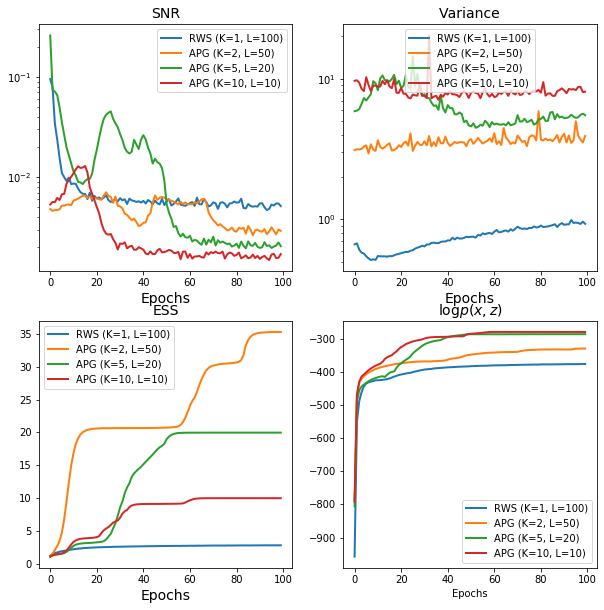

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
opacity=0.2
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(GRADS['snr_rws'].mean(0), linewidth=2.0, label='RWS (K=1, L=100)')
ax1.plot(np.reshape(GRADS['snr_apg2'].mean(0), (2,100))[1,:], linewidth=2.0, label='APG (K=2, L=50)')
ax1.plot(GRADS['snr_apg5'].mean(0), linewidth=2.0, label='APG (K=5, L=20)')
ax1.plot(np.reshape(GRADS['snr_apg10'].mean(0), (2,100))[1,:], linewidth=2.0, label='APG (K=10, L=10)')
# ax1.fill_between(np.arange(100), GRADS['snr_rws'].mean(0)-GRADS['snr_rws'].std(0), GRADS['snr_rws'].mean(0)+GRADS['snr_rws'].std(0), alpha=opacity)
# ax1.fill_between(np.arange(100), np.reshape(GRADS['snr_apg2'].mean(0), (2,100))[1,:]-np.reshape(GRADS['snr_apg2'].std(0), (2,100))[1,:], np.reshape(GRADS['snr_apg2'].mean(0), (2,100))[1,:]+np.reshape(GRADS['snr_apg2'].std(0), (2,100))[1,:], alpha=opacity)
# ax1.fill_between(np.arange(100), GRADS['snr_apg5'].mean(0)-GRADS['snr_apg5'].std(0), GRADS['snr_apg5'].mean(0)+GRADS['snr_apg5'].std(0), alpha=opacity)
# ax1.fill_between(np.arange(100), np.reshape(GRADS['snr_apg10'].mean(0), (2,100))[1,:]-np.reshape(GRADS['snr_apg10'].std(0), (2,100))[1,:], np.reshape(GRADS['snr_apg10'].mean(0), (2,100))[1,:]+np.reshape(GRADS['snr_apg10'].std(0), (2,100))[1,:], alpha=opacity)

ax1.legend(fontsize=10)
ax1.set_title('SNR', fontsize=14)
ax1.set_yscale('log')
ax1.set_xlabel('Epochs', fontsize=14)

ax1 = fig.add_subplot(2, 2, 2)
ax1.plot(GRADS['var_rws'].mean(0), linewidth=2.0, label='RWS (K=1, L=100)')
ax1.plot(np.reshape(GRADS['var_apg2'].mean(0), (2,100))[1,:], linewidth=2.0, label='APG (K=2, L=50)')
ax1.plot(GRADS['var_apg5'].mean(0), linewidth=2.0, label='APG (K=5, L=20)')
ax1.plot(np.reshape(GRADS['var_apg10'].mean(0), (2,100))[1,:], linewidth=2.0, label='APG (K=10, L=10)')
# ax1.fill_between(np.arange(100), GRADS['var_rws'].mean(0)-GRADS['var_rws'].std(0), GRADS['var_rws'].mean(0)+GRADS['var_rws'].std(0), alpha=opacity)
# ax1.fill_between(np.arange(100), np.reshape(GRADS['var_apg2'].mean(0), (2,100))[1,:]-np.reshape(GRADS['var_apg2'].std(0), (2,100))[1,:], np.reshape(GRADS['var_apg2'].mean(0), (2,100))[1,:]+np.reshape(GRADS['var_apg2'].std(0), (2,100))[1,:], alpha=opacity)
# ax1.fill_between(np.arange(100), GRADS['var_apg5'].mean(0)-GRADS['var_apg5'].std(0), GRADS['var_apg5'].mean(0)+GRADS['var_apg5'].std(0), alpha=opacity)
# ax1.fill_between(np.arange(100), np.reshape(GRADS['var_apg10'].mean(0), (2,100))[1,:]-np.reshape(GRADS['var_apg10'].std(0), (2,100))[1,:], np.reshape(GRADS['var_apg10'].mean(0), (2,100))[1,:]+np.reshape(GRADS['var_apg10'].std(0), (2,100))[1,:], alpha=opacity)

ax1.legend(fontsize=10)
ax1.set_title('Variance', fontsize=14)
ax1.set_yscale('log')
ax1.set_xlabel('Epochs', fontsize=14)


ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(METRICS['ess_rws'].mean(0), linewidth=2.0, label='RWS (K=1, L=100)')
ax3.plot(METRICS['ess_apg2'].mean(0), linewidth=2.0, label='APG (K=2, L=50)')
ax3.plot(METRICS['ess_apg5'].mean(0), linewidth=2.0, label='APG (K=5, L=20)')
ax3.plot(METRICS['ess_apg10'].mean(0), linewidth=2.0, label='APG (K=10, L=10)')
# ax3.fill_between(np.arange(100), METRICS['ess_rws'].mean(0)-METRICS['ess_rws'].std(0), METRICS['ess_rws'].mean(0)+METRICS['ess_rws'].std(0), alpha=opacity)
# ax3.fill_between(np.arange(100), METRICS['ess_apg2'].mean(0)-METRICS['ess_apg2'].std(0), METRICS['ess_apg2'].mean(0)+METRICS['ess_apg2'].std(0), alpha=opacity)
# ax3.fill_between(np.arange(100), METRICS['ess_apg5'].mean(0)-METRICS['ess_apg5'].std(0), METRICS['ess_apg5'].mean(0)+METRICS['ess_apg5'].std(0), alpha=opacity)
# ax3.fill_between(np.arange(100), METRICS['ess_apg10'].mean(0)-METRICS['ess_apg10'].std(0), METRICS['ess_apg10'].mean(0)+METRICS['ess_apg10'].std(0), alpha=opacity)

ax3.legend(fontsize=10)
ax3.set_title('ESS', fontsize=14)
# ax3.set_yscale('log')
ax3.set_xlabel('Epochs', fontsize=14)

ax3 = fig.add_subplot(2, 2, 4)
ax3.plot(METRICS['density_rws'].mean(0), linewidth=2.0, label='RWS (K=1, L=100)')
ax3.plot(METRICS['density_apg2'].mean(0), linewidth=2.0, label='APG (K=2, L=50)')
ax3.plot(METRICS['density_apg5'].mean(0), linewidth=2.0, label='APG (K=5, L=20)')
ax3.plot(METRICS['density_apg10'].mean(0), linewidth=2.0, label='APG (K=10, L=10)')

# ax3.fill_between(np.arange(100), METRICS['density_rws'].mean(0)-METRICS['density_rws'].std(0), METRICS['density_rws'].mean(0)+METRICS['density_rws'].std(0), alpha=opacity)
# ax3.fill_between(np.arange(100), METRICS['density_apg2'].mean(0)-METRICS['density_apg2'].std(0), METRICS['density_apg2'].mean(0)+METRICS['density_apg2'].std(0), alpha=opacity)
# ax3.fill_between(np.arange(100), METRICS['density_apg5'].mean(0)-METRICS['density_apg5'].std(0), METRICS['density_apg5'].mean(0)+METRICS['density_apg5'].std(0), alpha=opacity)
# ax3.fill_between(np.arange(100), METRICS['density_apg10'].mean(0)-METRICS['density_apg10'].std(0), METRICS['density_apg10'].mean(0)+METRICS['density_apg10'].std(0), alpha=opacity)

ax3.legend(fontsize=10)
ax3.set_title(r'$\log p(x, z)$', fontsize=14)
# ax3.set_yscale('log')
ax3.set_xlabel('Epochs')
plt.savefig('grads.png')